# Training a Single Layer Neural Network with Time Series Data

In [40]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# utilities 

In [63]:
def plot_series(time,series,format='-',start=0,end=None):
    plt.figure(figsize=(10,6))

    if type(series) is tuple:
        for series_num in series:
            plt.plot(time[start:end],series_num[start:end],format)

    else:
        plt.plot(time[start:end],series[start:end],format)

    plt.xlabel('time')
    plt.ylabel('value')
    plt.grid(True)
    plt.show()

def trend(time,slope=0):
    series=slope*time
    return series


def seasonal_pattern(season_time):
    data_pattern=np.where(season_time<0.4,np.cos(season_time*2*np.pi),1/np.exp(3*season_time))
    return data_pattern

def seasonality(time,period,amplitude=1,phase=0):
    season_time=((time+phase)%period)/period
    data_pattern=amplitude*seasonal_pattern(season_time)
    return data_pattern

def noise(time, noise_level=1,seed=None):
    rnd=np.random.RandomState(seed)
    noise=rnd.randn(len(time))*noise_level
    return noise

# generate the synthetic data

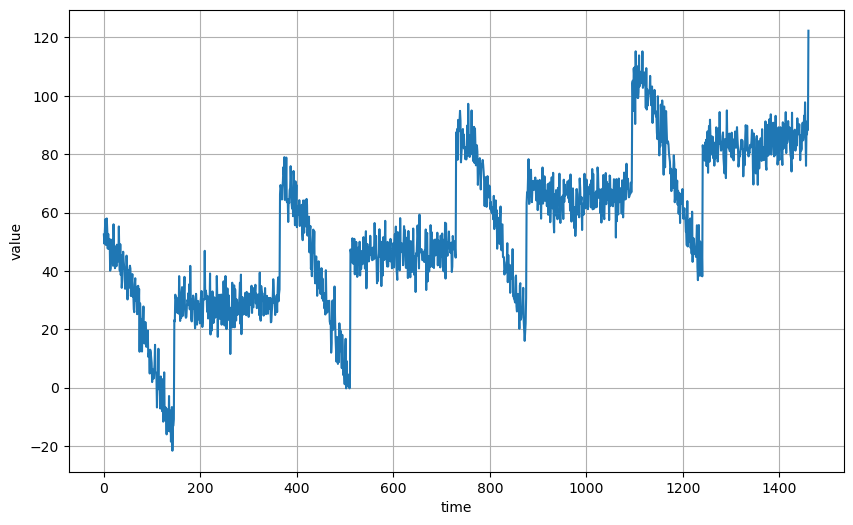

In [42]:
time=np.arange(4*365+1,dtype='float32')
baseline=10
amplitude=40
slope=0.05
noise_level=5

series=baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)

series+=noise(time,noise_level,seed=42)
plot_series(time,series)

# split the dataset

In [43]:
split_time=1000

time_train=time[:split_time]
x_train=series[:split_time]
time_valid=time[split_time:]
x_valid=series[split_time:]


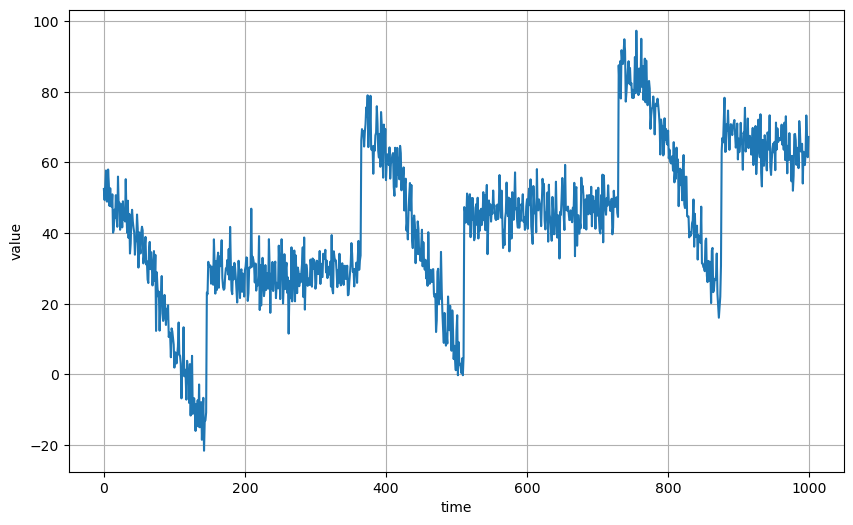

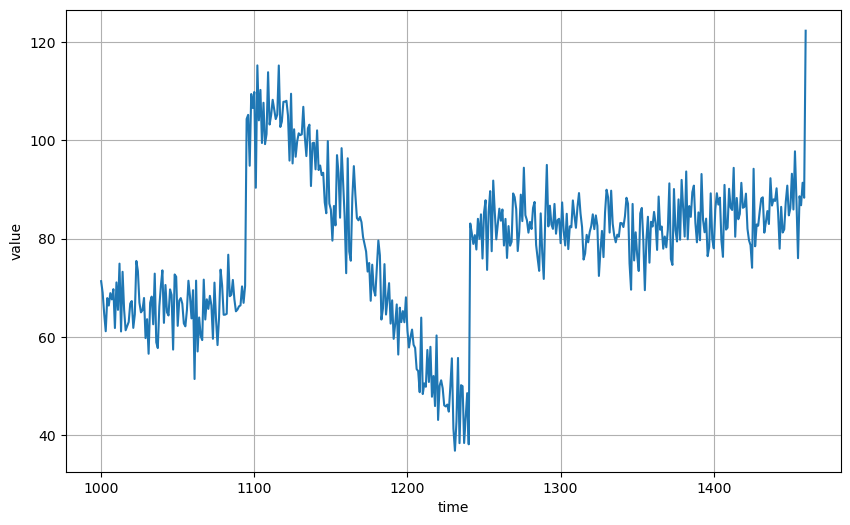

In [44]:
plot_series(time_train,x_train)
plot_series(time_valid,x_valid)

# prepare features and labels

In [45]:
window_size=20
batch_size=32
shuffle_buffer_size=1000

In [46]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
    dataset=tf.data.Dataset.from_tensor_slices(series)
    dataset=dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset=dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset=dataset.map(lambda window:(window[:-1],window[-1]))
    dataset=dataset.shuffle(shuffle_buffer)
    dataset=dataset.batch(batch_size).prefetch(1)
    return dataset

In [47]:
dataset=windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

In [48]:
for data in dataset.take(1):
    for i in data:
        print(i.numpy())

[[ 87.86698     91.473404    94.84867     91.54276     77.20444
   79.93713     83.12551     86.283035    88.6323      82.2952
   86.72619     81.8725      82.437515    78.29621     80.53653
   78.2063      79.88629     89.8238      79.58758     97.26462   ]
 [ 60.83839     47.617447    55.74531     58.221962    53.5481
   57.82629     49.2742      58.26888     62.078083    48.130997
   47.079636    55.936584    55.930805    44.782898    44.661682
   44.720486    38.77553     40.274677    39.219364    39.77539   ]
 [ 67.88892     75.451965    63.071606    65.68167     65.80888
   72.42587     64.03937     65.888794    67.5116      65.38417
   62.19856     65.38135     69.759796    59.24037     65.01968
   60.836647    70.29547     56.687828    61.493233    66.15852   ]
 [ 78.025826    76.279305    73.8866      70.71428     62.228306
   72.14295     70.48897     70.2582      61.960625    62.37761
   72.48181     66.44626     69.47453     65.62681     65.04757
   68.99935     61.132607  

In [49]:
for windows in dataset.take(1):
    print(f'data type:{type(windows)}')
    print(f'number of elements in the tuple {len(windows)}')
    print(f'shape of first element {windows[0].shape}')
    print(f'shape of second element {windows[1].shape}')

data type:<class 'tuple'>
number of elements in the tuple 2
shape of first element (32, 20)
shape of second element (32,)


# build and compile the model

In [50]:
l0=tf.keras.layers.Dense(1,input_shape=[window_size])
model=tf.keras.models.Sequential([l0])
print(l0.get_weights())
model.summary()

[array([[-0.38328078],
       [ 0.10795414],
       [ 0.01424068],
       [-0.5131458 ],
       [-0.35596806],
       [-0.1305964 ],
       [-0.2700142 ],
       [ 0.44193417],
       [-0.3856017 ],
       [ 0.24439555],
       [-0.21161732],
       [ 0.13921273],
       [ 0.22140789],
       [-0.45423523],
       [ 0.14480114],
       [ 0.47220522],
       [-0.19065586],
       [ 0.13180578],
       [ 0.52027863],
       [-0.47085467]], dtype=float32), array([0.], dtype=float32)]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9))

# Train the model

In [52]:
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 0s 4ms/step - loss: 1544.1888
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 200.7049
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 124.4870
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 116.8535
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 109.5370
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 106.0804
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 102.5034
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 98.2804
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 96.0746
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 92.7871
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 90.6047
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 88.1283
Epoch 13/100
31/3

In [53]:
print(l0.get_weights())

[array([[-0.08849636],
       [ 0.06217969],
       [ 0.06353188],
       [-0.04240517],
       [-0.01537535],
       [ 0.02883858],
       [-0.04077182],
       [ 0.10366312],
       [-0.09124231],
       [ 0.0687512 ],
       [-0.05213733],
       [ 0.03366751],
       [-0.00929757],
       [-0.04507285],
       [ 0.03037736],
       [ 0.13392031],
       [-0.02117043],
       [ 0.17283559],
       [ 0.3624016 ],
       [ 0.36875337]], dtype=float32), array([0.01862808], dtype=float32)]


# model prediction
To compute the metrics, you will want to generate model predictions for your validation set. Remember that this set refers to points at index 1000 to 1460 of the entire series. You will need to code the steps to generate those from your model. The cell below demonstrates one way of doing that.

Basically, it feeds the entire series to your model 20 points at a time and append all results to a forecast list. It will then slice the points that corresponds to the validation set.

The slice index below is split_time - window_size: because the forecast list is smaller than the series by 20 points (i.e. the window size). Since the window size is 20, the first data point in the forecast list corresponds to the prediction for time at index 20. You cannot make predictions at index 0 to 19 because those are smaller than the window size. Thus, when you slice with split_time - window_size:, you will be getting the points at the time indices that aligns with those in the validation set.

Note: You might notice that this cell takes a while to run. In the next two labs, you will see other approaches to generating predictions to make the code run faster. You might already have some ideas and feel free to try them out after completing this lab.

In [54]:
print(f'shape of series[0:20]:{series[0:20].shape}')
print(f'shape of series[0:20][np.newaxis]:{series[0:20][np.newaxis].shape}')
print(f'shape of series[0:20][np.newaxis]:{np.expand_dims(series[0:20],axis=0).shape}')
print(f'model prediction:{model.predict(series[0:20][np.newaxis])}')

shape of series[0:20]:(20,)
shape of series[0:20][np.newaxis]:(1, 20)
shape of series[0:20][np.newaxis]:(1, 20)
1/1 [==============================] - 0s 30ms/step
model prediction:[[46.202198]]


In [55]:
forecast=[]

for time in range(len(series)-window_size):
    forecast.append(model.predict(series[time:time+window_size][np.newaxis]))
forecast=forecast[split_time-window_size:]

print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

1/1 [==============================] - 0s 17ms/step
length of the forecast list: 461
shape of the validation set: (461,)


In [56]:
print(f'shape after converting to numpy array:{np.array(forecast).shape}')
print(f'shape after squeezing:{np.array(forecast).squeeze().shape}')

shape after converting to numpy array:(461, 1, 1)
shape after squeezing:(461,)


In [57]:
result=np.array(forecast).squeeze()
result.shape, x_valid.shape,time_valid.shape

((461,), (461,), (461,))

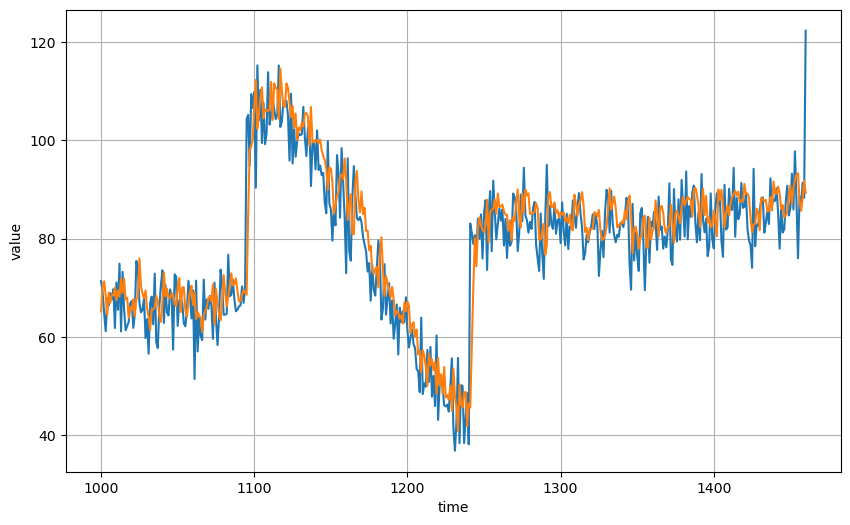

In [64]:
plot_series(time_valid, (x_valid,result))


In [66]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, result).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, result).numpy())

50.18598
5.406638
